# Auto correlation functions and FFTs
This tutorial provides some brief introduciton to auto-correlation functions (ACFs), fourier transforms and numerical tools for obtaining less noisy results.

For a complex time signal $x(t)$ the corresponding ACF is defined as
\begin{equation}
C(\tau) = \left < x(t) x^*(t+\tau) \right >
\end{equation}
and are typically normalized such that $C(\tau=0)=1$

## Damped harmonic oscillator
Here, we will consider a basic example where a the time-signal, $x(t)$, comes from a damped harmonic oscillator (DHO).    
We use a natrual frequency of the oscillator $f_0=1.0$ ($\omega_0 = 2 \pi$) and damping $\Gamma=0.25$ (lifetime $\tau=8$).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# DHO parameters
dt = 0.05
f0 = 1.0
w0 = np.pi * 2 * f0
gamma = 0.25

# read signal data and make up time array
signal = np.loadtxt('signal.txt')
time = np.arange(0,  len(signal), dt)
print('signal shape', signal.shape)

signal shape (29999,)


## Signal in time
Inspect a part of the signal in time.

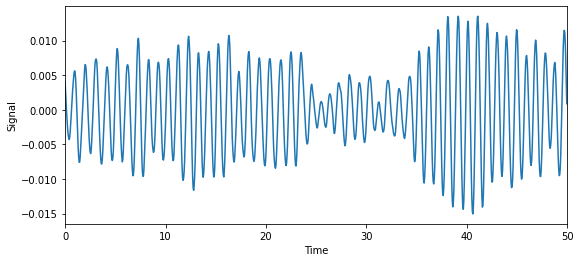

In [3]:
t_max = 1000
t_lim = [0, t_max * dt]
fig = plt.figure(figsize=(9, 4))
plt.plot(time[:t_max], signal[:t_max])
plt.xlim(t_lim)
plt.xlabel('Time')
plt.ylabel('Signal');

## Autocorrelation function
Here, we compare the calculated ACF with the analytical known solution for a DHO.
For longer time-scales we see the agreement become worse and worse due to the limited size of our time-signal (i.e. poor statistics).

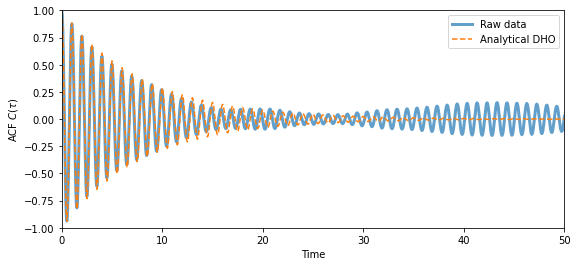

In [4]:
from dynasor.tools.acfs import compute_acf
from dynasor.tools.damped_harmonic_oscillator import acf_position_dho

t_acf, acf_raw = compute_acf(signal, delta_t=dt)
acf_analytical = acf_position_dho(t_acf, w0, gamma)

fig = plt.figure(figsize=(9, 4))
plt.plot(t_acf, acf_raw, lw=3.0, alpha=0.7, label='Raw data')
plt.plot(t_acf, acf_analytical, '--', label='Analytical DHO')
plt.legend(loc=1)
plt.xlim(t_lim)
plt.ylim([-1, 1])
plt.xlabel('Time')
plt.ylabel(r'ACF $C(\tau)$');

### Decay functions (smearing/smoothing)
The ACF above oscillates during the first 50 timesteps, and then decays towards zero after about 100 timesteps.
However, the ACF continous to oscillate even for longer times due to noise and insufficent sampling of the ACF.

This can be combated by artifically making the ACF decay towards zero, by multiplying the ACF with a decaying function.      
`dynasor` provides some utility functions for these things, for example a gaussian decay function (`gaussian_decay`) and a Fermi-Dirac like decay function (`fermi_dirac`).    
But other functions could of course be used and may be more suitable dependning on how the ACF looks like etc.

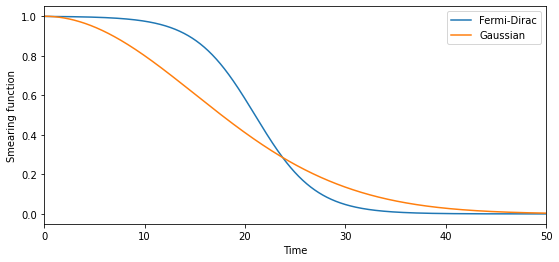

In [5]:
from dynasor.tools.acfs import fermi_dirac, gaussian_decay

t_decay = 15
decay_fermi = fermi_dirac(t_acf, t_0=1.4*t_decay, t_width=t_decay/5)
decay_gauss = gaussian_decay(t_acf, t_sigma=t_decay)

fig = plt.figure(figsize=(9, 4))
plt.plot(t_acf, decay_fermi, label='Fermi-Dirac')
plt.plot(t_acf, decay_gauss, label='Gaussian')
plt.legend(loc=1)
plt.xlim(t_lim)
plt.xlabel('Time')
plt.ylabel('Smearing function');

For simiplicity in this tutorial we will stick to using a Gaussian decay function, $f(t)$, defined as
\begin{equation}
f(t) = \exp{\left [-\frac{1}{2} \left (\frac{t}{t_\mathrm{sigma}}\right )^2 \right ] }
\end{equation}
where the parameter $t_\mathrm{sigma}$ is the "decay-time" of function.

In [6]:
# construct ACFs with decay functions applied
decay_times = [20, 10]
acf_gauss = dict()
for t_sigma in decay_times: 
    acf_gauss[t_sigma] = acf_raw * gaussian_decay(t_acf, t_sigma=t_sigma)

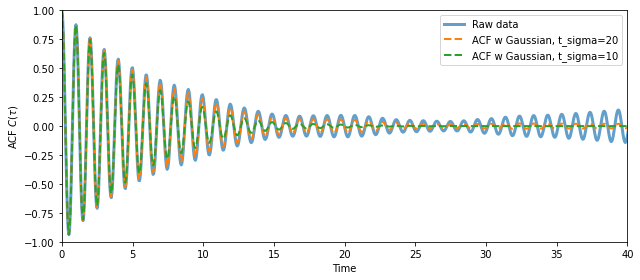

In [7]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)


plt.plot(t_acf, acf_raw, lw=3.0, alpha=0.7, label='Raw data')
for t_sigma, acf in acf_gauss.items():
    ax.plot(t_acf, acf, '--', lw=2.0, label=f'ACF w Gaussian, t_sigma={t_sigma}')

ax.legend(loc=1)
ax.set_xlim([0, 40])
ax.set_ylim([-1, 1])
ax.set_xlabel('Time')
ax.set_ylabel(r'ACF $C(\tau)$')
fig.tight_layout();

## Fourier transforms and spectral
ACFs can be fourier transformed to obtain the spectra of the time signal.
Assuming the time-signal is even we can use the fourier_cos_filon as implemented in dynasor.

Note here that applying a decaying function in the time-domain shows up as a smoothing or smearing function in the frequency domain.    
One can also apply smoothing/smearing functions directly on the spectra (in the frequency domain rather than in the timedomain), as demonstrated below with the helper function `smoothing_function`.
The `window_size` chosen for the smearing in frequency is roughly equivalent to applying a decay function in the time-domain with a decay-time of `1/window_size`.
There are many different window functions/shapes to chose from, , here we simply employ the default (Hamming)

Note one can also zero-pad the ACF (and apply other FFT tricks) to get a nicer looking spectra.

In [8]:
from dynasor.post_processing import fourier_cos_filon
from dynasor.tools.acfs import smoothing_function

In [9]:
n_max = 4999

# raw FFT
w, S_raw = fourier_cos_filon(acf_raw[:n_max], dt)
f = w / 2 / np.pi
delta_f = f[1] - f[0]

# gaussian ACFs
S_gauss = dict()
for t_sigma, acf in acf_gauss.items():
    _, S = fourier_cos_filon(acf[:n_max], dt)
    S_gauss[t_sigma] = S

# smearing
S_smear = dict()
for window_size in [5, 10, 20]:
    window = window_size * delta_f
    S_smear[window] = smoothing_function(S_raw, window_size=window_size)
    print('window_size in frequency', window)
    print('1/window_size in time', 1/window)

window_size in frequency 0.020008003201280513
1/window_size in time 49.98
window_size in frequency 0.040016006402561026
1/window_size in time 24.99
window_size in frequency 0.08003201280512205
1/window_size in time 12.495


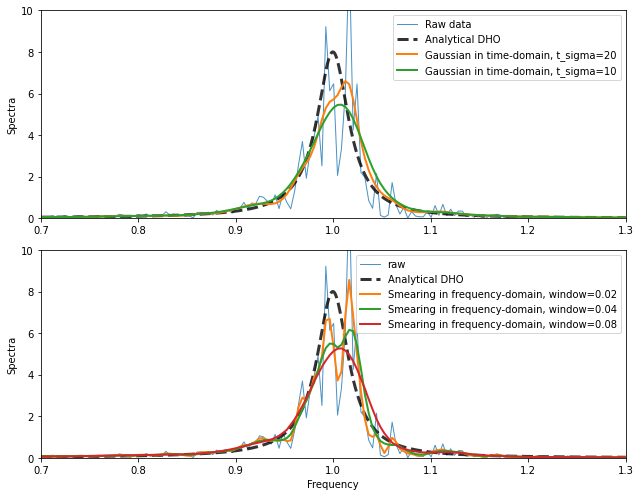

In [10]:
from dynasor.tools.damped_harmonic_oscillator import spectra_position_dho

f_lin = np.linspace(0, 2, 10000)
S_dho = spectra_position_dho(f_lin * np.pi * 2, w0, gamma)

fig = plt.figure(figsize=(9, 7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(f, S_raw, '-', lw=1.0, alpha=0.8, label='Raw data')
ax1.plot(f_lin, S_dho, '--k', lw=3.0, alpha=0.8, label='Analytical DHO')
for t_sigma, S in S_gauss.items():
    ax1.plot(f, S, '-', lw=2.0, label=f'Gaussian in time-domain, t_sigma={t_sigma}')

ax2.plot(f, S_raw, '-', lw=1.0, alpha=0.8, label='raw')
ax2.plot(f_lin, S_dho, '--k', lw=3.0, alpha=0.8, label='Analytical DHO')
for t_sigma, S in S_smear.items():
    ax2.plot(f, S, '-', lw=2.0, label=f'Smearing in frequency-domain, window={t_sigma:.2f}')

for ax in [ax1, ax2]:
    ax.legend(loc=1)
    ax.set_xlim([0.7, 1.3])
    ax.set_ylim([0, 10])
    ax.set_ylabel('Spectra')
ax2.set_xlabel('Frequency')
fig.tight_layout();

We expect the peak at 1.0 as this is the natrual frequency of the DHO. The width of the peak is the damping $\Gamma$.

Note here that a too agreesive decay-function in time or smearing function in frequency domain yields and artifically broader peak.